# Micrograd

This notebook aims to be a place to properly write Micrograd code

## Setting up

In [2]:
import matplotlib.pyplot as plt
from graphviz import Digraph
from numpy import *
import numpy as np
import warnings
import torch
import math

warnings.filterwarnings("ignore", category=DeprecationWarning)

## Starting the Value class

In [3]:
class Value:
    def __init__(self, data: float, _children: tuple = (), _op: str = '', label: str = ''):
        self._backward = lambda: None
        self._prev = set(_children)
        self.label = label
        self.data = data
        self._op = _op
        self.grad = 0.
        
    def __repr__(self) -> str:
        return f'Value(data={self.data})'
    
    def __radd__(self, new):
        new = new if isinstance(new, Value) else Value(new)
        return self + new
    
    def __add__(self, new: float):
        new = new if isinstance(new, Value) else Value(new)
        output = Value(self.data + new.data, (self, new), '+')
        
        def _backward():
            self.grad += 1. * output.grad
            new.grad += 1. * output.grad
        
        output._backward = _backward
        
        return output
    
    def __rmul__(self, new):
        new = new if isinstance(new, Value) else Value(new)
        return self * new
    
    def __mul__(self, new: float):
        new = new if isinstance(new, Value) else Value(new)
        output = Value(self.data * new.data, (self, new), '*')
        
        def _backward():
            self.grad += new.data * output.grad     
            new.grad += self.data * output.grad
                         
        output._backward = _backward
        
        return output
    
    def __rpow__(self, new):
        new = new if isinstance(new, Value) else Value(new)
        return Value(self.data ** new.data, (self, ), f'**{new}')
    
    def __pow__(self, new):
        assert isinstance(new, (int, float)), 'The code is only supporting integers or floating values for now.'

        output = Value(self.data ** new, (self, ), f'**{new}')
        
        def _backward():
            self.grad += new * self.data ** (new - 1) * output.grad
            
        output._backward = _backward
        
        return output
    
    def __rtruediv__(self, other):
        new = self if isinstance(other, float) else Value(other)
        output = Value(new.data / self.data, (new, self), '/')
        def _backward():
            new.grad -= 1. / (self.data ** 2) * output.grad
            self.grad += new.data / (self.data ** 2) * output.grad
        output._backward = _backward
        return output
    
    def __truediv__(self, new):
        new = new if isinstance(new, Value) else Value(new)
        return self * new ** -1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, new):
        new = new if isinstance(new, Value) else Value(new)
        return self + (-new)
    
    def exp(self):
        x = self.data
        output = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += output.data * output.grad
            
        output._backward = _backward

        return output
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        output = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * output.grad
            
        output._backward = _backward

        return output
    
    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.

        for node in reversed(topo):
            node._backward()

In [4]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
d = a * b; d.label = 'd'
e = d + c; e.label = 'e'

f = Value(-2., label='f(x)')
L = e * f; L.label = 'L'
print(f)
print(L)
f._prev, f._op, f.label

Value(data=-2.0)
Value(data=-8.0)


(set(), '', 'f(x)')

In [5]:
a = Value(2.)
b = Value(6)

a - 10

Value(data=-8.0)

## Defining the graphviz functions

In [6]:
def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR', 'bgcolor': 'black'}, node_attr={'color': 'gray'})
    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{ %s | node %.2f | grad %.2f }" % (n.label, n.data, n.grad), shape='record', fontcolor='white')

        if n._op:
            dot.node(name=uid + n._op, label=n._op, fontcolor='white')
            dot.edge(uid + n._op, uid, color='white')

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op, color='white')

    return dot

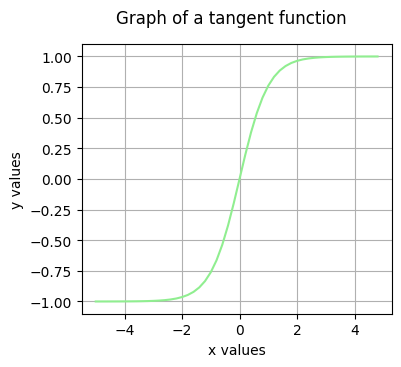

In [7]:
xs = np.arange(-5, 5, .2)
ys = np.arange(-5, 5, .2)

plt.figure(figsize=(4, 3.5))

plt.plot(xs, np.tanh(ys), color='lightgreen')

# plt.style.use('dark_background')

plt.suptitle('Graph of a tangent function')
plt.xlabel('x values')
plt.ylabel('y values')

plt.grid()
plt.show()

## Backpropagation in a perceptron 

In [8]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'w. x1'
x2w2 = x2*w2; x2w2.label = 'w. x2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'w. sum'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

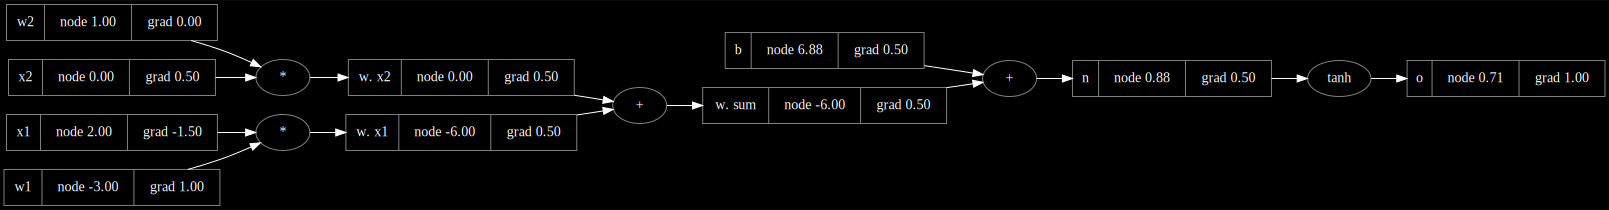

In [9]:
o.backward()
draw_dot(o)

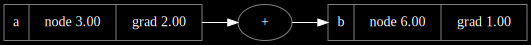

In [10]:
a = Value(3., label = 'a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

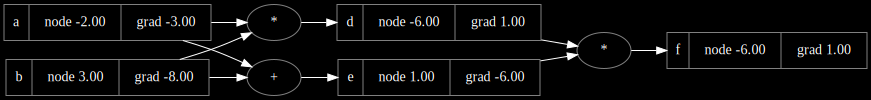

In [11]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'

f.backward()

draw_dot(f)

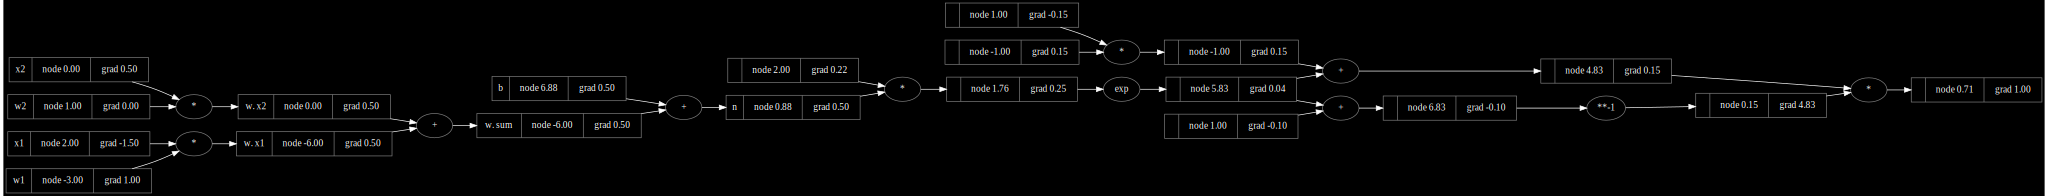

In [12]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'w. x1'
x2w2 = x2*w2; x2w2.label = 'w. x2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'w. sum'

n = x1w1x2w2 + b; n.label = 'n'

e = (2 * n).exp()

o = (e - 1) / (e + 1)

o.backward()

draw_dot(o)

## Pytorch implementation

In [13]:
import torch

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [14]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1 ,1))

    with np.testing.suppress_warnings():
        def __call__(self, x):
            act = np.sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
            output = act.tanh()

            return output

    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outputs = list([n(x) for n in self.neurons])
        
        return outputs[0] if len(outputs) == 1 else outputs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [15]:
x = list([2., 3.])
n = Neuron(2)
print('n(x):', n(x))

draw_dot(n(x))

print('parameters:', n.parameters())

n(x): Value(data=0.6241707923249564)
parameters: [Value(data=-0.7156807330602384), Value(data=0.7210568016389092), Value(data=0.1039616642912673)]


In [16]:
x = list([2., 3., -1.])
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.28615999817158116)

In [17]:
len(n.parameters()), n.parameters()

(41,
 [Value(data=-0.018956436278632083),
  Value(data=-0.853824005427601),
  Value(data=-0.5432161143528003),
  Value(data=-0.18442093446968166),
  Value(data=0.1230766430202086),
  Value(data=-0.4495204359223002),
  Value(data=0.15080041560554736),
  Value(data=-0.8130731154694815),
  Value(data=0.5007514945813973),
  Value(data=-0.11498345453904957),
  Value(data=0.062886283342374),
  Value(data=0.5768831202948357),
  Value(data=0.2925341839854658),
  Value(data=-0.9070106893508485),
  Value(data=-0.3995963870887902),
  Value(data=-0.9570683718858728),
  Value(data=-0.7644190531222608),
  Value(data=0.47083220894273503),
  Value(data=-0.6734117786717773),
  Value(data=-0.9882514820794568),
  Value(data=-0.9796697437418074),
  Value(data=0.3446921170731665),
  Value(data=-0.6215514979026671),
  Value(data=-0.12058426666967037),
  Value(data=0.17902691230267265),
  Value(data=-0.00997544396262029),
  Value(data=0.883192277238386),
  Value(data=0.789452623097699),
  Value(data=-0.94372

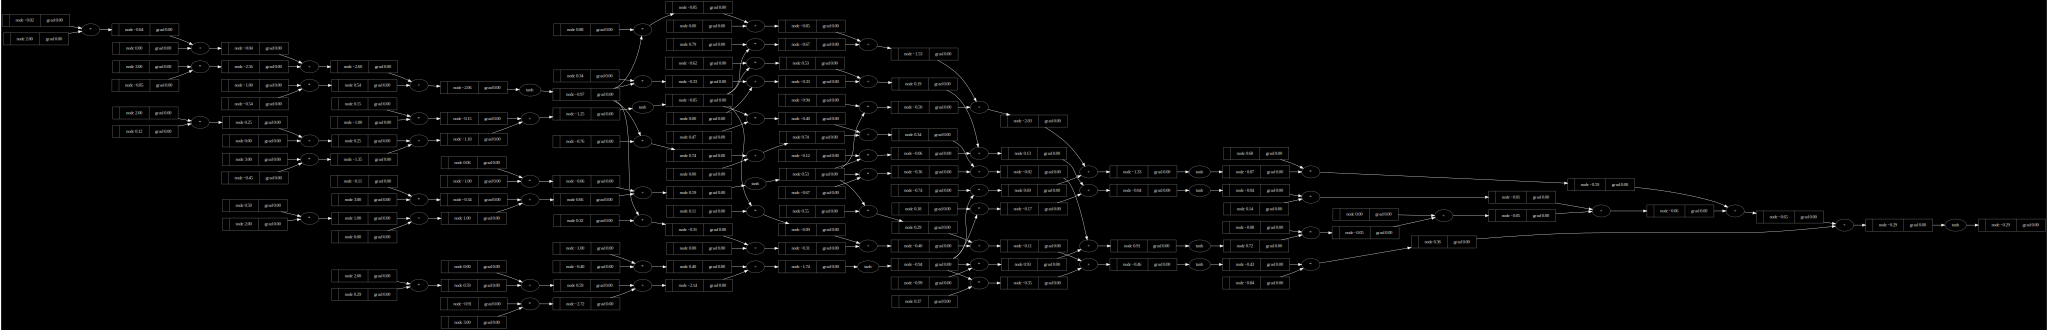

In [18]:
draw_dot(n(x))

In [19]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]

In [20]:
for k in range(10):    
    y_pred = list([n(x) for x in xs])
    loss = sum([(yout - ygt) ** 2 for ygt, yout in zip(ys, y_pred)])

    for p in n.parameters():
        p.grad = 0.
        
    loss.backward()
    
    lr = -5e-2
    
    for p in n.parameters():
        p.data += lr * p.grad
        
    print(k, loss.data)

0 4.469220690361493
1 2.215513642927519
2 1.4857965082015976
3 1.0107803083312856
4 0.6824022357196601
5 0.47366920835890064
6 0.344312337677475
7 0.26211145728467705
8 0.2075380005694657
9 0.1696316303838119


In [21]:
print(n.layers[0].neurons[0].w[0], n.layers[0].neurons[0].w[0].grad, n.layers[0].neurons[0].w[0].data)
    
print()
print(ys)
print([f'{y_pred.data:.1f}' for y_pred in y_pred])

Value(data=0.015948710757028053) -0.017524505436250677 0.015948710757028053

[1.0, -1.0, -1.0, 1.0]
['0.8', '-0.9', '-0.7', '0.8']
